<h1><br><br>AMS 2013-2014 Solar Energy Prediction Contest</h1><br><br>

<h3>Description of the competition :</h3>

<b>AMS 2013-2014 Solar Energy Prediction Contest</b> is a solar energy forecast competition organized by the American Meteorological Society on applications of artificial intelligence to environmental science, probabilities and statistics, as well as the Earth and energy.<br><br>
The goal of this competition is to predict solar energy at Oklahoma Mesonet stations (red dots) from weather forecasts for GEFS points (blue dots):

<center><img src="http://cs.ou.edu/~djgagne/gefs_mesonet_stations.png" width="800" align="middle"></center>

<h3>Importing the libraries :</h3>

In [1]:
import csv
import os
import netCDF4 as nc
import numpy as np 
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

<h3>Loading the GEFS files :</h3>

Predictions from GEFS points are provided as 30 <font color="red">NetCDF</font> files:  
- 15 train files. 
- 15 test files.


<b>Each file contains:</b>
- The grids of each member of the ensemble at each time step for a particular variable.
- Latitude-longitude grid and time step values, as well as metadata listing the full names of each variable and associated units.
- All data for one of the variables of the model stored in a multidimensional array.


**These variables have 5 dimensions:**
- Time: information about 5113 consecutive days. 
- Hours of predictions: Five forecasts for different hours are made for each day.
- Latitude of the GEFS points.
- Longitude of the GEFS points.
- Weather model: 11 meteorological forecast models, called ensembles.

Load the 15 training features (1 feature per file) : 

In [26]:
def load_GEFS_data(directory,files_to_use,file_sub_str):
    for i,f in enumerate(files_to_use):
        if i == 0:
            X = load_GEFS_file(directory,files_to_use[i],file_sub_str)
        else:
            X_new = load_GEFS_file(directory,files_to_use[i],file_sub_str)
            X = np.hstack((X,X_new))
    return X

In [27]:
def load_GEFS_file(directory,data_type,file_sub_str):
    print('loading',data_type)
    path = os.path.join(directory,data_type+file_sub_str)
    X = list(nc.Dataset(path,'r+').variables.values())[-1][:,:,:,3:7,3:13] # get rid of some GEFS points
    #X = list(nc.Dataset(path,'r+').variables.values())[-1][:]
    #X = X.reshape(X.shape[0],55,4,10) 								 # Reshape to merge sub_models and time_forcasts
    X = np.mean(X,axis=1) 											 # Average models, but not hours
    X = X.reshape(X.shape[0],np.prod(X.shape[1:])) 					 # Reshape into (n_examples,n_features)
    return X

<i> PS: the 2 previous functions were obtained from Alec Radford's code available on Github: https://github.com/cyberport-kaggle/ams-solar</i>

In [4]:
X=load_GEFS_data("gefs_train/train/",["apcp_sfc","dlwrf_sfc","dswrf_sfc","pres_msl","pwat_eatm","spfh_2m","tcdc_eatm",
                                   "tcolc_eatm","tmax_2m","tmin_2m","tmp_2m","tmp_sfc","ulwrf_sfc","ulwrf_tatm","uswrf_sfc"],
               "_latlon_subset_19940101_20071231.nc")

loading apcp_sfc
loading dlwrf_sfc
loading dswrf_sfc
loading pres_msl
loading pwat_eatm
loading spfh_2m
loading tcdc_eatm
loading tcolc_eatm
loading tmax_2m
loading tmin_2m
loading tmp_2m
loading tmp_sfc
loading ulwrf_sfc
loading ulwrf_tatm
loading uswrf_sfc


Save the X array in a csv file to speed up the process :

In [7]:
import numpy
numpy.savetxt("Xdata.csv", X, delimiter=",")

Get the X array from the csv file rather than using the 2 previous functions:

In [2]:
from numpy import genfromtxt
X = genfromtxt('Xdata.csv', delimiter=',')

In [4]:
X.shape

(5113, 3000)

Load the 15 test features (1 feature per file) :

In [28]:
Xt=load_GEFS_data("gefs_test/test/",["apcp_sfc","dlwrf_sfc","dswrf_sfc","pres_msl","pwat_eatm","spfh_2m","tcdc_eatm",
                                   "tcolc_eatm","tmax_2m","tmin_2m","tmp_2m","tmp_sfc","ulwrf_sfc","ulwrf_tatm","uswrf_sfc"],
               "_latlon_subset_20080101_20121130.nc")

loading apcp_sfc
loading dlwrf_sfc
loading dswrf_sfc
loading pres_msl
loading pwat_eatm
loading spfh_2m
loading tcdc_eatm
loading tcolc_eatm
loading tmax_2m
loading tmin_2m
loading tmp_2m
loading tmp_sfc
loading ulwrf_sfc
loading ulwrf_tatm
loading uswrf_sfc


<h3>Loading the train csv file  :</h3>

The <b>train.csv</b> file contains all of the daily incoming solar energy in (J m-2) at 98 Mesonet sites in Oklahoma operating continuously since January 1, 1994. Solar energy was measured directly by a pyrometer every 5 minutes at each Mesonet site and summarized sunrise at 23:55 UTC from the date indicated in each column.

In [3]:
def load_csv_data(path):
    data = np.loadtxt(path,delimiter=',',dtype=float,skiprows=1)
    times = data[:,0].astype(int)
    Y = data[:,1:]
    return times,Y

In [4]:
times,y=load_csv_data("ydata.csv")

In [5]:
y.shape

(5113, 98)

In [15]:
#normalizing the features
#from sklearn.preprocessing import normalize
#X_normalized = normalize(X,norm='l2')

In [9]:
timest,yt=load_csv_data("sampleSubmission.csv")

<h3> Training the models and evaluating their performance :</h3>

Once the data preparation finished, the next step focuses on training the models and evaluating their performance.<br>
The 6 following algorithms are implemented :
- Linear Regression
- Decision Tree
- LASSO
- Ridge
- ANN (Sequential, using Keras)
- Random Forest


In [17]:
# cross-validation technique
#SEED=45
#def cv_loop(X, y, model, N):
#    MAEs = 0
#    for i in range(N):
#        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state = i*SEED)
#        model.fit(X_train, y_train)
#        preds = model.predict(X_test)
#        mae = metrics.mean_absolute_error(y_test,preds)
#        print ("MAE (fold %d/%d): %f" % (i + 1, N, mae))
#        MAEs += mae
#   return MAEs/N

Perform a holdout to split the data into training (80%) and test (20%) sets :

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 45)

The function below will be used to plot the learning curve of each model :

In [46]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_scores = -train_scores
    test_scores = -test_scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Training data')
    plt.ylabel(r'MAE')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show() 

- **Ridge**

In [62]:
rdg_train = Ridge(normalize=True,alpha=0.31)
rdg_train.fit(X_train, y_train)
preds = rdg_train.predict(X_test)
mae1 = metrics.mean_absolute_error(y_test,preds)
mae1

2220281.250306921

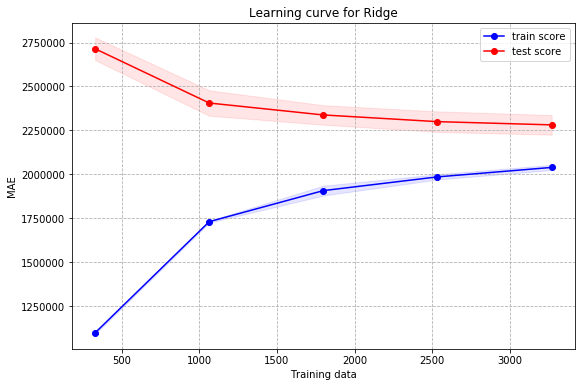

In [63]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(rdg_train, X= X_train, y = y_train, 
                                            cv= 5,  scoring='neg_mean_absolute_error')

fig_rdg=plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for Ridge') 

- **Linear Regression**

In [64]:
from sklearn.linear_model import LinearRegression
lr_train = LinearRegression()
lr_train.fit(X_train, y_train)
preds = lr_train.predict(X_test)
mae2 = metrics.mean_absolute_error(y_test,preds)
mae2

4820050.111314697

In [16]:
lr.coef_

array([[ 357089.25486853, -762690.44274899,  404147.35556214, ...,
         103797.88856189, -227600.90147123, -138626.96905671],
       [ 215578.0163503 , -213102.80460426,  243708.56468207, ...,
         368195.31835245, -249152.43660486,  -23705.62215457],
       [-115406.554185  , -515351.32567284,  385859.04098262, ...,
         199222.74726134, -417283.43977651, -206032.1175905 ],
       ...,
       [ -54653.4249599 ,  477453.80686822, -143003.30098441, ...,
         106256.74762518, -263255.79771959,   85710.71374015],
       [  73238.80972959,  -52175.41028679,  -61191.14474904, ...,
        -296622.68025926, -107051.83949238, -161455.70499823],
       [  26666.65703   , -143076.80322561,  336235.61046109, ...,
        -100680.99658608,  176743.99330259, -220131.34040997]])

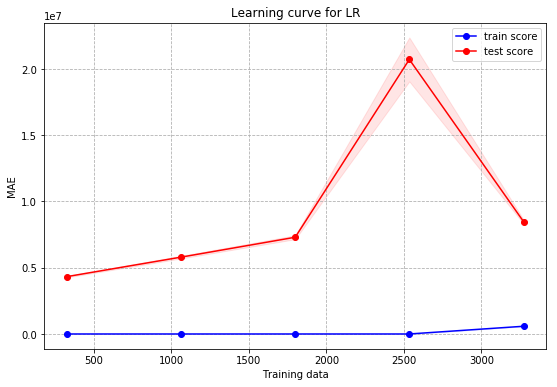

In [65]:
# Plot the learning curve
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(lr_train, X= X_train, y = y_train, 
                                            cv= 5,  scoring='neg_mean_absolute_error')

fig_lr=plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for LR') 

In [17]:
X.shape

(5113, 3000)

In [18]:
X_train.shape

(4090, 3000)

- **Decision Tree**

In [59]:
from sklearn.tree import DecisionTreeRegressor
regressor_train = DecisionTreeRegressor(max_depth=7)
regressor_train.fit(X_train, y_train)
preds = regressor_train.predict(X_test)
mae32 = metrics.mean_absolute_error(y_test,preds)
mae32

2772460.56113074

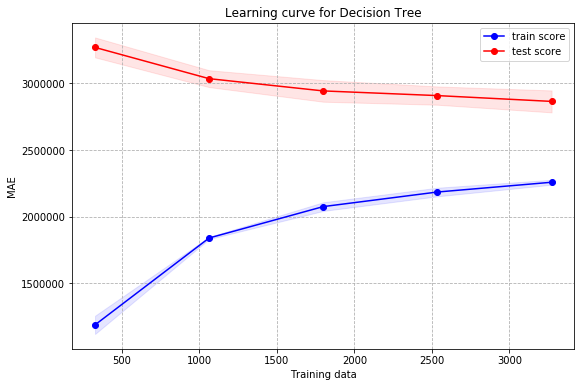

In [68]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(regressor_train, X= X_train, y = y_train, 
                                            cv= 5,  scoring='neg_mean_absolute_error')

fig_dt=plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for Decision Tree') 

- **Lasso**

In [70]:
from sklearn import linear_model
lso_train = linear_model.Lasso(alpha=0.3,normalize=True)
lso_train.fit(X_train, y_train)
preds = lso_train.predict(X_test)
mae4 = metrics.mean_absolute_error(y_test,preds)
mae4

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


2910628.7779700425

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

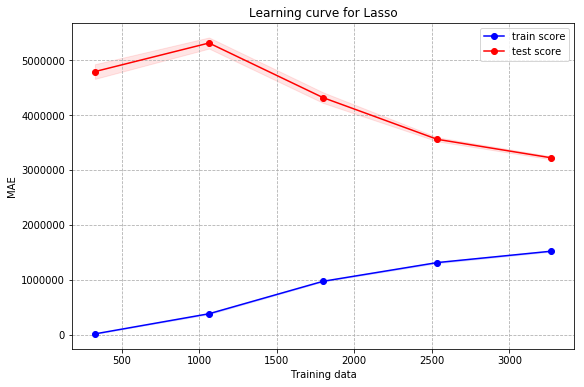

In [71]:
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(lso_train, X= X_train, y = y_train, 
                                            cv= 5,  scoring='neg_mean_absolute_error')

fig_lso=plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for Lasso') 

- **ANN (Sequential)**

In [74]:
import keras
from keras.layers import Dense
from keras.models import Sequential

In [75]:
#Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
#from sklearn.decomposition import PCA
#pca = PCA(n_components=8)
#pca.fit(X_train)
#X_train_pca = pca.transform(X_train)
#pca.fit(X_test)
#X_test_pca = pca.transform(X_test)

In [120]:
model_train = Sequential()

In [122]:
model_train.add(Dense(300, activation='relu', input_shape = (3000,)))
model_train.add(Dense(250, activation='relu'))
model_train.add(Dense(200, activation='relu'))
model_train.add(Dense(150, activation='relu'))

model_train.add(Dense(98, kernel_initializer='normal'))

In [123]:
model_train.compile(optimizer='adam', loss='mean_absolute_error')

In [95]:
history=model_train.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=1000)

Train on 4090 samples, validate on 1023 samples
Epoch 1/1000
4090/4090 [==============================] - 4s 1ms/step - loss: 8394721.2100 - val_loss: 7140546.2380
Epoch 2/1000
4090/4090 [==============================] - 4s 865us/step - loss: 6735358.1174 - val_loss: 6622104.3886
Epoch 3/1000
4090/4090 [==============================] - 3s 843us/step - loss: 6466116.6751 - val_loss: 6316793.3211
Epoch 4/1000
4090/4090 [==============================] - 3s 777us/step - loss: 5162628.5713 - val_loss: 3638523.9394
Epoch 5/1000
4090/4090 [==============================] - 3s 801us/step - loss: 3567493.8328 - val_loss: 3275569.3380
Epoch 6/1000
4090/4090 [==============================] - 3s 784us/step - loss: 3466766.7248 - val_loss: 3465207.9440
Epoch 7/1000
4090/4090 [==============================] - 3s 781us/step - loss: 3317022.2199 - val_loss: 3057430.2534
Epoch 8/1000
4090/4090 [==============================] - 3s 781us/step - loss: 3389048.3879 - val_loss: 3723418.4756
Epoch 9/10

4090/4090 [==============================] - 3s 841us/step - loss: 2645053.5924 - val_loss: 2614222.7522
Epoch 138/1000
4090/4090 [==============================] - 4s 876us/step - loss: 2720171.4373 - val_loss: 2524059.1645
Epoch 139/1000
4090/4090 [==============================] - 4s 867us/step - loss: 2665006.5279 - val_loss: 2509622.4641
Epoch 140/1000
4090/4090 [==============================] - 4s 870us/step - loss: 2644877.8309 - val_loss: 2490022.9394
Epoch 141/1000
4090/4090 [==============================] - 3s 819us/step - loss: 2717073.1534 - val_loss: 2485661.0980
Epoch 142/1000
4090/4090 [==============================] - 3s 820us/step - loss: 2647866.9197 - val_loss: 2553599.7991
Epoch 143/1000
4090/4090 [==============================] - 3s 830us/step - loss: 2607532.7176 - val_loss: 2698062.6987
Epoch 144/1000
4090/4090 [==============================] - 3s 825us/step - loss: 2661559.7308 - val_loss: 2487796.6784
Epoch 145/1000
4090/4090 [=============================

4090/4090 [==============================] - 3s 769us/step - loss: 2433360.5167 - val_loss: 2309965.1183
Epoch 274/1000
4090/4090 [==============================] - 3s 836us/step - loss: 2435165.5742 - val_loss: 2368473.4570
Epoch 275/1000
4090/4090 [==============================] - 3s 840us/step - loss: 2442487.1068 - val_loss: 2350871.5606
Epoch 276/1000
4090/4090 [==============================] - 4s 869us/step - loss: 2430787.0222 - val_loss: 2331597.3179
Epoch 277/1000
4090/4090 [==============================] - 3s 813us/step - loss: 2450919.1778 - val_loss: 2475385.4875
Epoch 278/1000
4090/4090 [==============================] - 3s 783us/step - loss: 2472795.9156 - val_loss: 2457413.6894
Epoch 279/1000
4090/4090 [==============================] - 3s 822us/step - loss: 2497798.8884 - val_loss: 2352527.4335
Epoch 280/1000
4090/4090 [==============================] - 4s 944us/step - loss: 2453764.8735 - val_loss: 2438829.2612
Epoch 281/1000
4090/4090 [=============================

Epoch 409/1000
4090/4090 [==============================] - 3s 751us/step - loss: 2384155.8191 - val_loss: 2337094.5078
Epoch 410/1000
4090/4090 [==============================] - 3s 773us/step - loss: 2437111.6023 - val_loss: 2412763.2478
Epoch 411/1000
4090/4090 [==============================] - 3s 769us/step - loss: 2409912.3340 - val_loss: 2567240.6576
Epoch 412/1000
4090/4090 [==============================] - 3s 794us/step - loss: 2412280.1614 - val_loss: 2302819.7908
Epoch 413/1000
4090/4090 [==============================] - 3s 824us/step - loss: 2379958.2752 - val_loss: 2495013.1532
Epoch 414/1000
4090/4090 [==============================] - 3s 820us/step - loss: 2389010.1314 - val_loss: 2309982.0391
Epoch 415/1000
4090/4090 [==============================] - 3s 800us/step - loss: 2390403.9044 - val_loss: 2519294.8925
Epoch 416/1000
4090/4090 [==============================] - 3s 825us/step - loss: 2389512.3210 - val_loss: 2412852.1933
Epoch 417/1000
4090/4090 [==============

4090/4090 [==============================] - 3s 843us/step - loss: 2343889.2485 - val_loss: 2255713.7268
Epoch 546/1000
4090/4090 [==============================] - 3s 852us/step - loss: 2366228.0484 - val_loss: 2418409.3788
Epoch 547/1000
4090/4090 [==============================] - 4s 874us/step - loss: 2383132.0897 - val_loss: 2284518.3431
Epoch 548/1000
4090/4090 [==============================] - 4s 876us/step - loss: 2356611.8829 - val_loss: 2358699.4690
Epoch 549/1000
4090/4090 [==============================] - 4s 879us/step - loss: 2364821.3142 - val_loss: 2267892.8568
Epoch 550/1000
4090/4090 [==============================] - 4s 890us/step - loss: 2358493.5584 - val_loss: 2249779.1762
Epoch 551/1000
4090/4090 [==============================] - 4s 867us/step - loss: 2393706.6676 - val_loss: 2316166.9189
Epoch 552/1000
4090/4090 [==============================] - 3s 820us/step - loss: 2366070.6605 - val_loss: 2297908.9560
Epoch 553/1000
4090/4090 [=============================

4090/4090 [==============================] - 4s 884us/step - loss: 2345189.8348 - val_loss: 2276241.1410
Epoch 682/1000
4090/4090 [==============================] - 3s 843us/step - loss: 2354191.3784 - val_loss: 2240432.7505
Epoch 683/1000
4090/4090 [==============================] - 3s 803us/step - loss: 2342020.1174 - val_loss: 2475665.4453
Epoch 684/1000
4090/4090 [==============================] - 3s 810us/step - loss: 2384961.7850 - val_loss: 2297376.1701
Epoch 685/1000
4090/4090 [==============================] - 3s 806us/step - loss: 2355783.7403 - val_loss: 2438362.6953
Epoch 686/1000
4090/4090 [==============================] - 3s 812us/step - loss: 2363416.5770 - val_loss: 2241656.5108
Epoch 687/1000
4090/4090 [==============================] - 3s 825us/step - loss: 2349251.0952 - val_loss: 2243428.1950
Epoch 688/1000
4090/4090 [==============================] - 4s 894us/step - loss: 2318442.1699 - val_loss: 2233260.1613
Epoch 689/1000
4090/4090 [=============================

4090/4090 [==============================] - 3s 794us/step - loss: 2318020.9138 - val_loss: 2219463.1296
Epoch 818/1000
4090/4090 [==============================] - 3s 855us/step - loss: 2296009.7262 - val_loss: 2263853.7739
Epoch 819/1000
4090/4090 [==============================] - 3s 843us/step - loss: 2372925.8539 - val_loss: 2234628.4238
Epoch 820/1000
4090/4090 [==============================] - 3s 823us/step - loss: 2319493.2771 - val_loss: 2269306.2314
Epoch 821/1000
4090/4090 [==============================] - 3s 854us/step - loss: 2318782.7609 - val_loss: 2313478.9734
Epoch 822/1000
4090/4090 [==============================] - 3s 830us/step - loss: 2315470.0152 - val_loss: 2363617.7901
Epoch 823/1000
4090/4090 [==============================] - 3s 842us/step - loss: 2326544.2289 - val_loss: 2233108.8458
Epoch 824/1000
4090/4090 [==============================] - 3s 820us/step - loss: 2347705.8947 - val_loss: 2265801.6230
Epoch 825/1000
4090/4090 [=============================

4090/4090 [==============================] - 3s 851us/step - loss: 2290402.0310 - val_loss: 2238029.1476
Epoch 954/1000
4090/4090 [==============================] - 3s 844us/step - loss: 2298634.6071 - val_loss: 2237582.5349
Epoch 955/1000
4090/4090 [==============================] - 3s 852us/step - loss: 2271604.4925 - val_loss: 2350221.6938
Epoch 956/1000
4090/4090 [==============================] - 4s 894us/step - loss: 2292289.7057 - val_loss: 2418003.1777
Epoch 957/1000
4090/4090 [==============================] - 4s 874us/step - loss: 2307888.0790 - val_loss: 2249827.4157
Epoch 958/1000
4090/4090 [==============================] - 4s 872us/step - loss: 2270479.7592 - val_loss: 2364511.4047
Epoch 959/1000
4090/4090 [==============================] - 4s 889us/step - loss: 2290869.4577 - val_loss: 2226799.8324
Epoch 960/1000
4090/4090 [==============================] - 4s 870us/step - loss: 2339376.6122 - val_loss: 2244099.8115
Epoch 961/1000
4090/4090 [=============================

In [17]:
mae5 = model_train.evaluate(X_test, y_test)
mae5

1023/1023 [==============================] - 0s 86us/step


2201384.5373900295

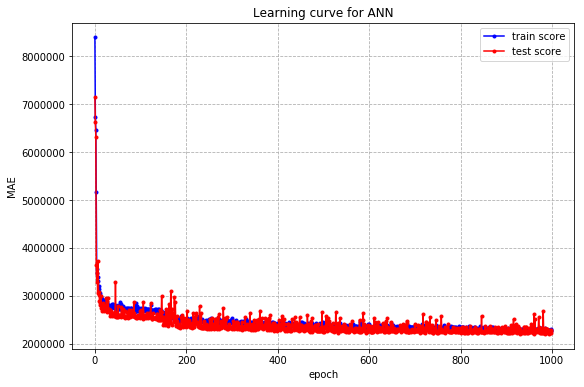

In [119]:
# summarize history for loss
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'], '.-',color='blue')
plt.plot(history.history['val_loss'], '.-',color='red')
plt.title('Learning curve for ANN')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train score', 'test score'])
plt.grid(ls='--')
plt.show()

- **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
#RFR2=MultiOutputRegressor(RandomForestRegressor(max_depth=6,n_estimators=2000))
RFR_train=MultiOutputRegressor(RandomForestRegressor(max_depth=6,n_estimators=50))
RFR_train.fit(X_train, y_train)
y_pred = RFR_train.predict(X_test)
mae6 = metrics.mean_absolute_error(y_test,y_pred)
mae6

In [ ]:
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(RFR_train, X= X_train, y = y_train, 
                                            cv= 5,  scoring='neg_mean_absolute_error')

fig_dt=plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for Random Forest') 

<h3>Comparing the models' scores :</h3>

The following table exposes the MAE values of the 6 implemented models. <br>
The model with the best performance achieved in the training set is : <b><font color="red">ANN</font></b>.

In [3]:
import pandas as pd 
d = {'Ridge': [mae1], 'Linear Regression': [mae2], 'Decision Tree': [mae3],'Lasso': [mae4], 'ANN': [mae5],
    'Random Forest':[mae6]}
df = pd.DataFrame(data=d)
df.index=["MAE"]
df

,Ridge,Linear Regression,Decision Tree,Lasso,ANN,Random Forest
MAE,2220281.25,4820050.11,2778880.91,2910628.77,2201384.53,2219867.17


D:\Programs\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5,1,"Models' MAEs")

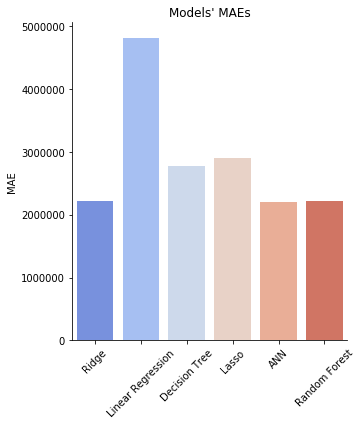

In [5]:
import seaborn as sns
sns.factorplot(data=df,kind="bar",palette='coolwarm')
plt.xticks(rotation=45)
plt.ylabel("MAE")
plt.title("Models' MAEs")

<h3> Submission :</h3>

The prediction of the solar energy for the test data <i>(2008-2012)</i> was established using the 6 regression models. Only the best-performing model is shown below, namely <b>Ridge</b> with a MAE of <b>2215228,56</b> (<b>10th</b> position on the Kaggle leaderboard). 

In [31]:
def save_submission(preds,submit_name,data_dir):
    fexample = open(os.path.join(data_dir,'sampleSubmission.csv'))
    fout = open(submit_name,'w')
    fReader = csv.reader(fexample,delimiter=',', skipinitialspace=True)
    fwriter = csv.writer(fout)
    for i,row in enumerate(fReader):
        if i == 0:
            fwriter.writerow(row)
        else:
            row[1:] = preds[i-1]
            fwriter.writerow(row)
    fexample.close()
    fout.close()

In [167]:
rdg.fit(X, y)
preds = rdg.predict(Xt)

In [168]:
preds

array([[13302338.3879839 , 12756611.90784663, 13408555.37107326, ...,
        11669061.64929141, 13087143.19941786, 11373132.70945111],
       [13088778.7350356 , 12891632.25993098, 12234305.13190265, ...,
        12575286.61532   , 12813277.31156163, 12013687.50117391],
       [ 9793925.12208393,  9428090.17335328,  9795625.01446661, ...,
         9838419.42229974, 10839212.9578099 , 10014259.0207254 ],
       ...,
       [13413646.41022521, 13104984.78342165, 13409379.76552138, ...,
        12923586.01824962, 13035172.22643182, 12090474.30742207],
       [12934592.89881983, 13236627.52148563, 12731292.83465722, ...,
        13390228.27250288, 12823821.13525411, 11877911.47400852],
       [ 9149858.899222  ,  7311403.68387721, 11629451.44359381, ...,
         8038614.75900139, 11200305.53487116,  6912709.49053797]])

In [170]:
save_submission(preds,'submission2.csv',"data/")

<img src="http://image.noelshack.com/fichiers/2018/49/6/1544286181-submission.png" style="width: 80%; height: 80%"/>